In [1]:
import numpy as np
import pandas as pd

import bt
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.random.seed(0)
returns =  np.random.normal(0.08/12,0.2/np.sqrt(12),12*10) # 每个月的模拟收益率（单利）

In [3]:
returns

array([ 0.10851428,  0.02976975,  0.06317413,  0.1360447 ,  0.11449018,
       -0.0497565 ,  0.06152005, -0.00207195,  0.00070732,  0.03037258,
        0.01498303,  0.09062919,  0.0506052 ,  0.01369158,  0.03229312,
        0.02593136,  0.09292736, -0.00517815,  0.02474164, -0.04264457,
       -0.14073027,  0.04440335,  0.05657491, -0.03618225,  0.13771101,
       -0.07730117,  0.00930854, -0.0041404 ,  0.09516172,  0.09150013,
        0.01561256,  0.02849989, -0.04458967, -0.10769467, -0.01342005,
        0.01569348,  0.07769753,  0.0760861 , -0.01569566, -0.01078679,
       -0.05387157, -0.07531811, -0.09184489,  0.11929474, -0.02275812,
       -0.01862556, -0.06566351,  0.05155509, -0.08651177, -0.0056159 ,
       -0.04503312,  0.02900449, -0.02282468, -0.06149716,  0.00503956,
        0.03139642,  0.01050704,  0.02412989, -0.02995594, -0.0142762 ,
       -0.03215786, -0.01409214, -0.04028036, -0.09300031,  0.01691037,
       -0.01653017, -0.08745288,  0.03338541, -0.04571623,  0.00

In [5]:
np.cumprod(1+returns) # 每个月的模拟收益率（复利）

array([1.10851428, 1.14151447, 1.21362866, 1.3787364 , 1.53658817,
       1.46013293, 1.54996037, 1.54674894, 1.54784299, 1.59485498,
       1.61875073, 1.7654568 , 1.85479809, 1.8801932 , 1.94091051,
       1.99124097, 2.17628174, 2.16501262, 2.21857858, 2.12396824,
       1.82506162, 1.90610048, 2.01393795, 1.94106914, 2.20837573,
       2.0376657 , 2.05663338, 2.0481181 , 2.24302053, 2.44825721,
       2.48648078, 2.55734521, 2.44331403, 2.18018213, 2.15092398,
       2.18467946, 2.35442366, 2.53356257, 2.49379664, 2.46689658,
       2.334001  , 2.15820846, 1.95998804, 2.1938043 , 2.14387745,
       2.10394652, 1.96579401, 2.06714071, 1.88830871, 1.87770416,
       1.79314528, 1.84515455, 1.80303948, 1.69215767, 1.70068541,
       1.75408084, 1.77251104, 1.81528153, 1.76090307, 1.73576406,
       1.67994561, 1.65627158, 1.58955637, 1.44172714, 1.46610728,
       1.44187228, 1.3157764 , 1.35970414, 1.29754359, 1.3100853 ,
       1.37396602, 1.39335749, 1.49430623, 1.39773514, 1.43952

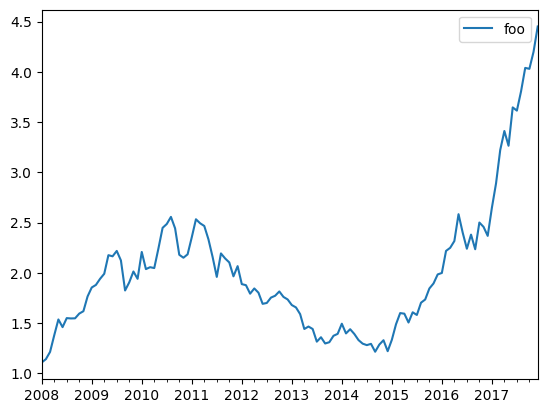

In [6]:
pdf = pd.DataFrame(
    np.cumprod(1+returns),
    index = pd.date_range(start="2008-01-01",periods=12*10,freq="m"),
    columns=['foo']
)

pdf.plot();

In [7]:
pdf # 每个月的期末价值

,foo
2008-01-31,1.108514
2008-02-29,1.141514
2008-03-31,1.213629
2008-04-30,1.378736
2008-05-31,1.536588
...,...
2017-08-31,3.806344
2017-09-30,4.039887
2017-10-31,4.030665
2017-11-30,4.200438


# 这个直接就是 Monthly 的数据

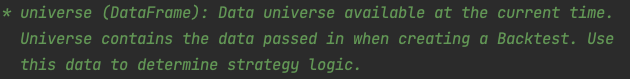

In [39]:
runMonthlyAlgo = bt.algos.RunMonthly()
rebalAlgo = bt.algos.Rebalance()

class Signal(bt.Algo):

    """

    Mostly copied from StatTotalReturn

    Sets temp['Signal'] with total returns over a given period.

    Sets the 'Signal' based on the total return of each
    over a given lookback period.

    Args:
        * lookback (DateOffset): lookback period.
        * lag (DateOffset): Lag interval. Total return is calculated in
            the inteval [now - lookback - lag, now - lag]

    Sets:
        * stat

    Requires:
        * selected

    """

    def __init__(self, lookback=pd.DateOffset(months=3),
                 lag=pd.DateOffset(days=0)):
        super(Signal, self).__init__()
        self.lookback = lookback
        self.lag = lag

    def __call__(self, target):
        selected = 'foo'
        t0 = target.now - self.lag # 当前时间 target.now 不可获取，只能获取 target.now - self.lag；这个是做Lag特征普遍的注意点
#         print(f'target.now: {target.now}')
#         print(f't0: {t0}')
#         print(f'target.universe: \n{target.universe}')
        if target.universe[selected].index[0] > t0: # 如果 t0 < virtual start node; 则返回 False，不进行后续计算
            return False
        prc = target.universe[selected].loc[t0 - self.lookback:t0] # prc is abbr. for price
#         print(f'prc:\n{prc}')
        
        trend = prc.iloc[-1]/prc.iloc[0] - 1
        signal = trend > 0.
#         print(f'trend: {trend}')
        if signal:
            target.temp['Signal'] = 1.
        else:
            target.temp['Signal'] = 0.
#         print('\n')
        return True

signalAlgo = Signal(pd.DateOffset(months=12), pd.DateOffset(months=1))

class WeighFromSignal(bt.Algo):

    """
    Sets temp['weights'] from the signal.
    Sets:
        * weights

    Requires:
        * selected

    """

    def __init__(self):
        super(WeighFromSignal, self).__init__()

    def __call__(self, target):
        selected = 'foo'
        print(f'target.now: {target.now}')
        print('target.temp[Signal]')
        print(target.temp['Signal'])
        if target.temp['Signal'] is None:
            raise(Exception('No Signal!'))
        target.temp['weights'] = {selected : target.temp['Signal']}
        return True

weighFromSignalAlgo = WeighFromSignal()

s = bt.Strategy(
    'example1',
    [
        runMonthlyAlgo,
        signalAlgo,
        weighFromSignalAlgo,
        rebalAlgo
    ]
)

t = bt.Backtest(s, pdf, integer_positions=False, progress_bar=True)

In [40]:
res = bt.run(t)

example1
target.now: 2008-03-31 00:00:00
target.temp[Signal]
0.0
target.now: 2008-04-30 00:00:00
target.temp[Signal]
0.0
0% [#                             ] 100% | ETA: 00:00:00target.now: 2008-05-31 00:00:00
target.temp[Signal]
0.0
target.now: 2008-06-30 00:00:00
target.temp[Signal]
0.0
target.now: 2008-07-31 00:00:00
target.temp[Signal]
0.0
target.now: 2008-08-31 00:00:00
target.temp[Signal]
0.0
0% [##                            ] 100% | ETA: 00:00:00target.now: 2008-09-30 00:00:00
target.temp[Signal]
0.0
target.now: 2008-10-31 00:00:00
target.temp[Signal]
0.0
target.now: 2008-11-30 00:00:00
target.temp[Signal]
0.0
target.now: 2008-12-31 00:00:00
target.temp[Signal]
0.0
0% [###                           ] 100% | ETA: 00:00:00target.now: 2009-01-31 00:00:00
target.temp[Signal]
0.0
target.now: 2009-02-28 00:00:00
target.temp[Signal]
0.0
target.now: 2009-03-31 00:00:00
target.temp[Signal]
1.0
target.now: 2009-04-30 00:00:00
target.temp[Signal]
1.0
0% [####                          ] 100

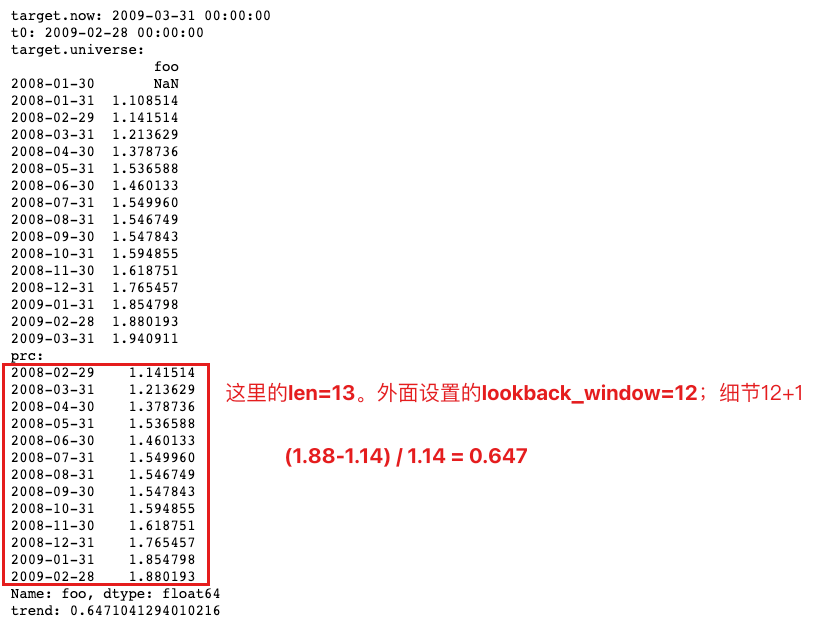

In [42]:
pd.set_option('display.max_rows', 200)

In [43]:
t.positions

,foo
2008-01-30,0.000000
2008-01-31,0.000000
2008-02-29,0.000000
2008-03-31,0.000000
2008-04-30,0.000000
2008-05-31,0.000000
2008-06-30,0.000000
2008-07-31,0.000000
2008-08-31,0.000000
2008-09-30,0.000000


In [ ]:
总结一下：
1. 通过 signalAlgo 来计算 Foo 的指标
2. 在 WighFromSignalAlgo 中获取 SignalAlgo中的参数，然后优化 weights
3. 后续如果要计算自己的 Signal Algo的话，我猜测是自定义 XXX_Indicator_Algo，然后计算好了以后，在下一个Weights中优化权重；

In [44]:
res.stats

,example1
start,2008-01-30 00:00:00
end,2017-12-31 00:00:00
rf,0.0
total_return,1.810698
cagr,0.109805
max_drawdown,-0.267046
calmar,0.411186
mtd,0.05991
three_month,0.102033
six_month,0.22079
